In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random
import os
import numpy as np


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

In [3]:
res = []
for file_path in glob.glob('../data/*.csv'):
    res.append(pd.read_csv(file_path))
df = pd.concat(res).sort_values('datetime').reset_index(drop=True)

In [4]:
df.head(3)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,final_opponent,datetime
0,蒼樹山,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,200001
1,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001
2,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001


In [5]:
df = df.dropna().reset_index(drop=True)

In [6]:
len(df)

4340

In [7]:
df.rename(columns={'day_15': 'final_day'}, inplace=True)
df['wins_at_day_14'] = df.iloc[:, df.columns.str.startswith('day_')].sum(axis=1)
# df.rename(columns={'final_day': 'day_15'}, inplace=True)

In [8]:
df.head(3)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,final_day,final_opponent,datetime,wins_at_day_14
0,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001,6.0
1,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001,7.0
2,曙,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,貴乃花,200001,11.0


Text(0, 0.5, '人数')

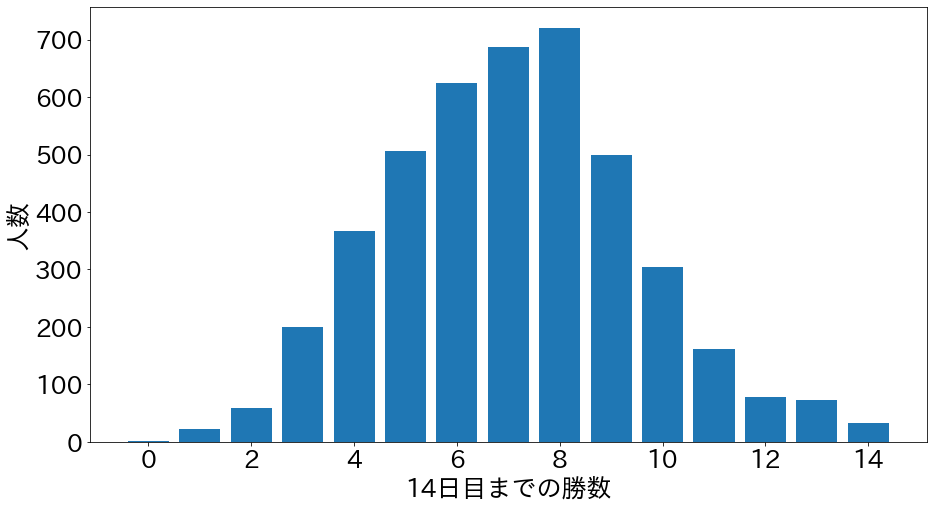

In [9]:
plt.rcParams["font.size"] = 25
plt.figure(figsize=(15, 8))
plt.bar(
    df.groupby('wins_at_day_14')['final_day'].count().index,
    df.groupby('wins_at_day_14')['final_day'].count()    
)
plt.xlabel('14日目までの勝数')
plt.ylabel('人数')

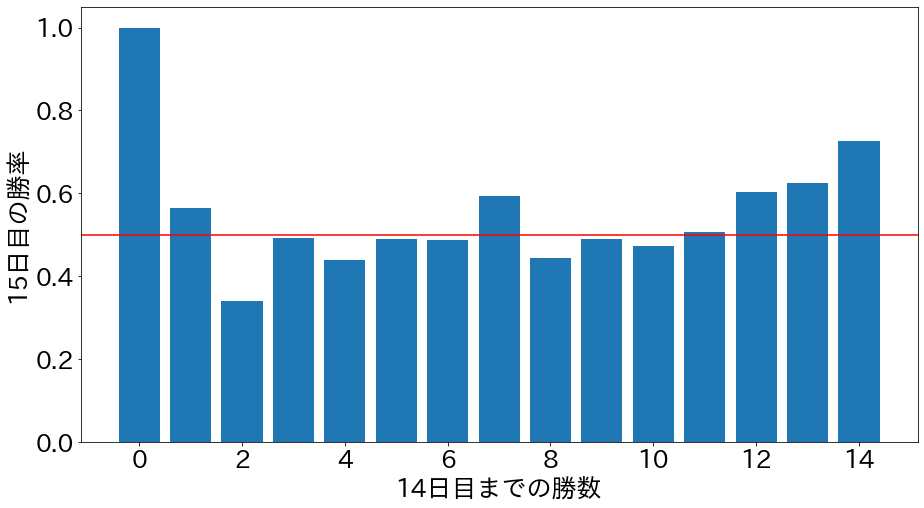

In [10]:
plt.rcParams["font.size"] = 25
plt.figure(figsize=(15, 8))
plt.bar(
    df.groupby('wins_at_day_14')['final_day'].mean().index,
    df.groupby('wins_at_day_14')['final_day'].mean()    
)
plt.xlabel('14日目までの勝数')
plt.ylabel('15日目の勝率')
plt.axhline(y=0.5, color='r', linestyle='-')

# features

In [11]:
df.head(2)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,final_day,final_opponent,datetime,wins_at_day_14
0,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001,6.0
1,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001,7.0


In [12]:
_tmp = df[['wrestler', 'datetime', 'wins_at_day_14']].rename(columns={'wrestler': 'final_opponent', 'wins_at_day_14': 'final_opponent_wins_at_day_14'})
df = pd.merge(df, _tmp, on=['final_opponent', 'datetime'], how='left')

In [13]:
split_datetime = 201501
train = df[df['datetime']<split_datetime]
test = df[~(df['datetime']<split_datetime)]

# benchmark

In [14]:
TRAIN_COL = list(df.iloc[:, df.columns.str.startswith('day_')].columns) + ['wins_at_day_14']
TARGET = 'final_day'

X_train = train[TRAIN_COL]
X_test = test[TRAIN_COL]

y_train = train[TARGET]
y_test = test[TARGET]

In [15]:
import pandas as pd
import lightgbm as lgb


def lgbm(X_tr, X_val, y_tr, y_val, X_test, params, categorical_features):

    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=categorical_features)

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=10000,
        early_stopping_rounds=30,
        verbose_eval=10
    )

    y_valid = model.predict(X_val)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns.values
    fold_importance_df["importance"] = model.feature_importance(importance_type='gain')

    return y_pred, y_valid, model, fold_importance_df


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [16]:
from sklearn.model_selection import KFold, TimeSeriesSplit
import seaborn as sns


N_SPLITS = 8

lgbm_params = {
    'max_depth': 16,
    'num_leaves': 4,
    'min_data_in_leaf': 10,
    'objective': 'binary',
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "feature_fraction": 0.7,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "metric": 'auc',
    "lambda_l1": 0.3,
    "verbosity": -1,
    "random_state": 42,
  }

categorical_features = list(df.iloc[:, df.columns.str.startswith('day_')].columns)

METRIC = 'auc'

In [17]:
y_preds = []
models = []
feature_importances = pd.DataFrame()
oof_train = np.zeros((len(X_train),))

cv = TimeSeriesSplit(n_splits=N_SPLITS)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    y_pred, y_val, model, fold_importance_df = lgbm(
        X_tr, X_val, y_tr, y_val, X_test, lgbm_params, categorical_features
    )

    oof_train[valid_index] = y_val
    y_preds.append(y_pred)
    models.append(model)
    feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.664237	valid_1's auc: 0.476116
[20]	training's auc: 0.708649	valid_1's auc: 0.448161
[30]	training's auc: 0.732841	valid_1's auc: 0.451331
Early stopping, best iteration is:
[1]	training's auc: 0.603798	valid_1's auc: 0.505077
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.634138	valid_1's auc: 0.561813
[20]	training's auc: 0.66299	valid_1's auc: 0.540893
[30]	training's auc: 0.672909	valid_1's auc: 0.543506
Early stopping, best iteration is:
[7]	training's auc: 0.625374	valid_1's auc: 0.563405
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.610419	valid_1's auc: 0.523368
[20]	training's auc: 0.624017	valid_1's auc: 0.505947
[30]	training's auc: 0.633629	valid_1's auc: 0.497342
[40]	training's auc: 0.64141	valid_1's auc: 0.502748
Early stopping, best iteration is:
[17]	training's auc: 0.62141	valid_1's auc: 0.524269
Training unt

In [18]:
scores = [
    m.best_score['valid_1'][METRIC] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.5050772096376855, 0.5634048176848682, 0.5242686369916502, 0.586021021021021, 0.5183260229525927, 0.538268676435263, 0.543306495223217, 0.5660091274845374]
0.5430852509288544


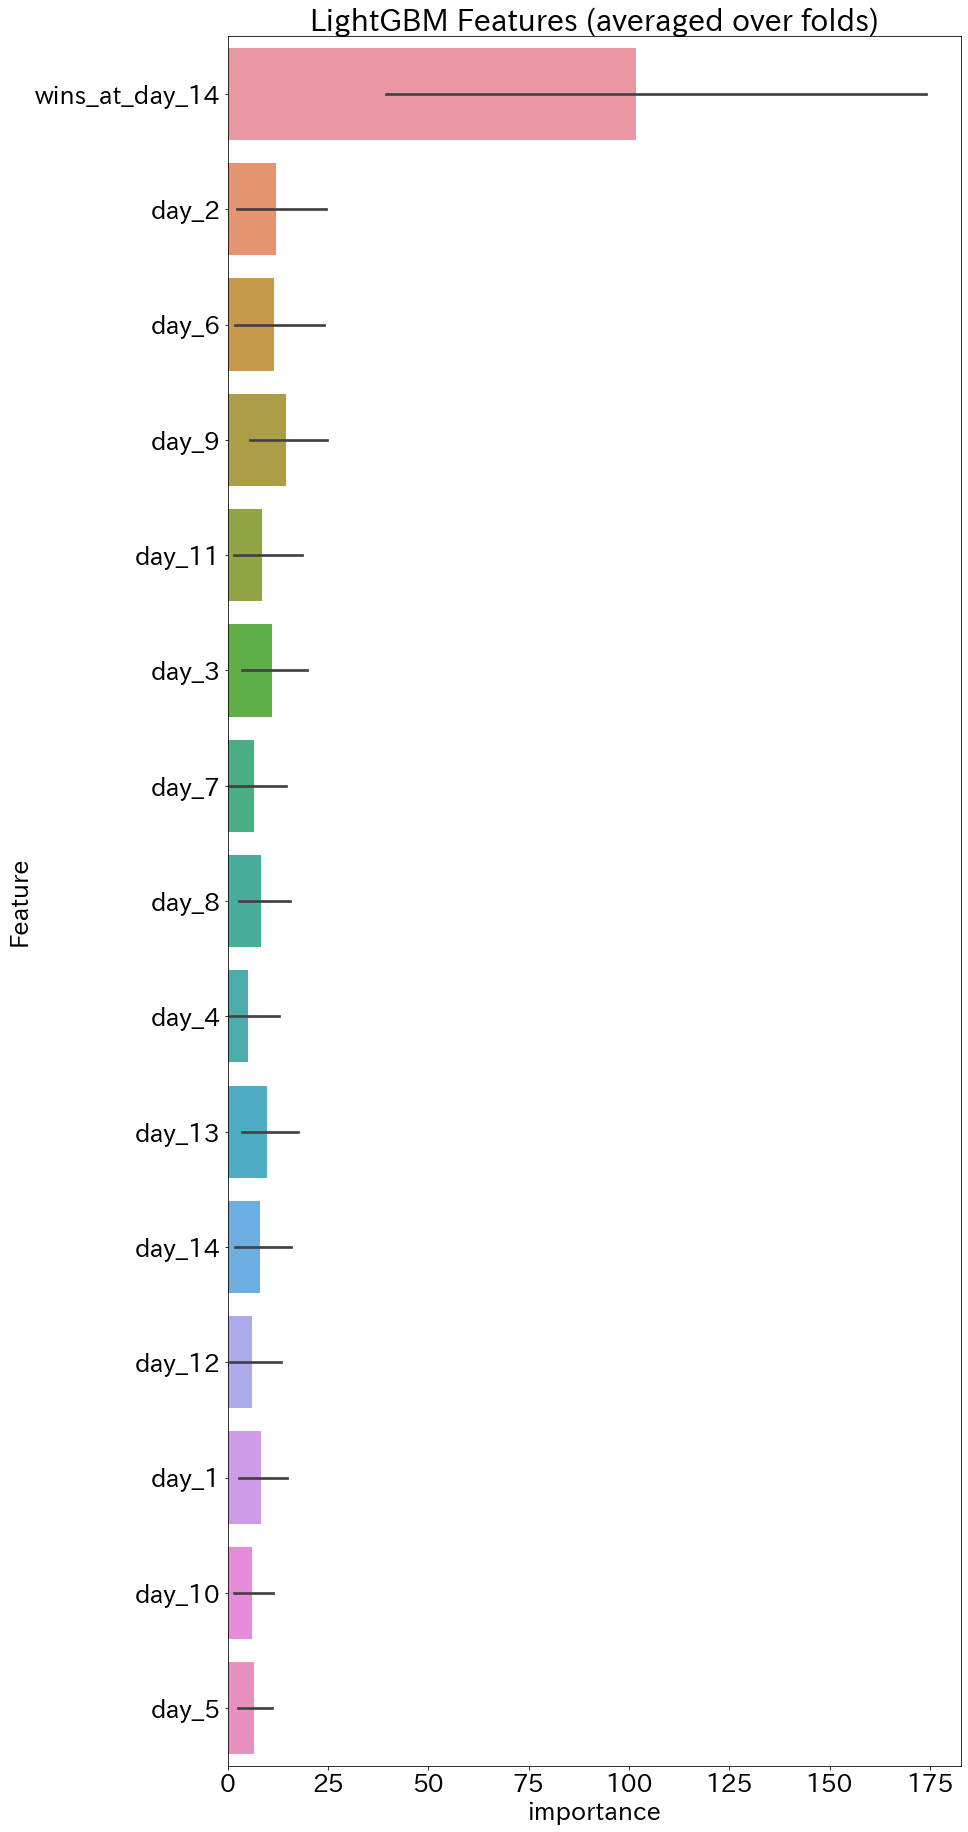

In [19]:
cols = feature_importances.groupby('Feature').mean().sort_values(by="importance", ascending=False)[:200].index

best_features = feature_importances.loc[feature_importances.Feature.isin(cols)]
plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [20]:
y_sub = sum(y_preds) / len(y_preds)
y_sub[:10]

array([0.49130919, 0.46664069, 0.5117093 , 0.47737384, 0.47137281,
       0.4985631 , 0.52938724, 0.5074412 , 0.55376889, 0.46534268])

(array([ 15.,  97., 236., 242., 164., 102., 119.,  51.,  17.,   7.]),
 array([0.433631  , 0.44909219, 0.46455339, 0.48001458, 0.49547578,
        0.51093697, 0.52639817, 0.54185936, 0.55732056, 0.57278175,
        0.58824295]),
 <a list of 10 Patch objects>)

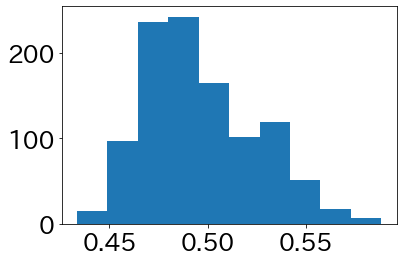

In [21]:
plt.hist(y_sub)

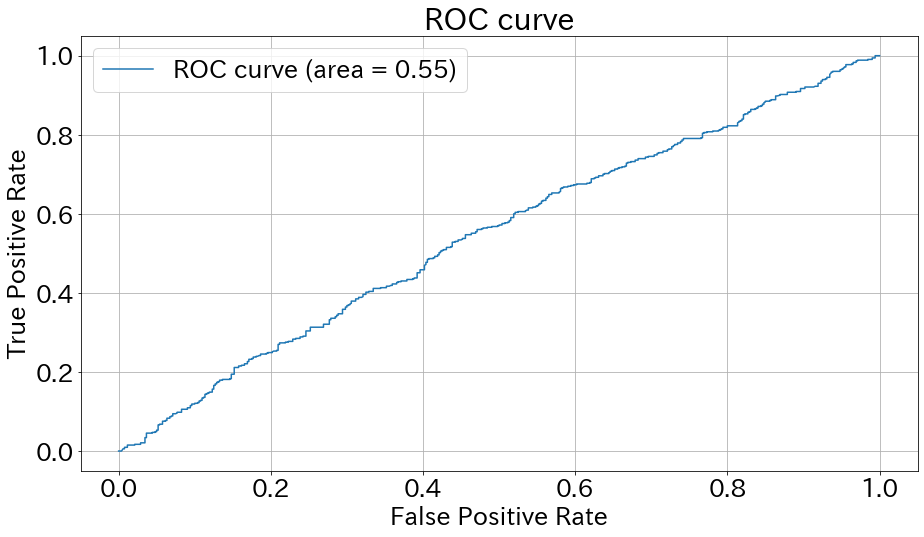

In [22]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_sub)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [23]:
y_sub = np.where(y_sub > 0.5, 1, 0)
y_sub[:10]

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_sub)

array([[341, 179],
       [311, 219]])

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_sub)

0.5333333333333333

# add feature

In [26]:
TRAIN_COL = list(df.iloc[:, df.columns.str.startswith('day_')].columns) + ['wins_at_day_14', 'final_opponent_wins_at_day_14']
TARGET = 'final_day'

X_train = train[TRAIN_COL]
X_test = test[TRAIN_COL]

y_train = train[TARGET]
y_test = test[TARGET]

In [27]:
y_preds = []
models = []
feature_importances = pd.DataFrame()
oof_train = np.zeros((len(X_train),))

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    y_pred, y_val, model, fold_importance_df = lgbm(
        X_tr, X_val, y_tr, y_val, X_test, lgbm_params, categorical_features
    )

    oof_train[valid_index] = y_val
    y_preds.append(y_pred)
    models.append(model)
    feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)


Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.699007	valid_1's auc: 0.502358
[20]	training's auc: 0.739182	valid_1's auc: 0.481524
[30]	training's auc: 0.752155	valid_1's auc: 0.491228
Early stopping, best iteration is:
[2]	training's auc: 0.629613	valid_1's auc: 0.516749
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.634472	valid_1's auc: 0.585886
[20]	training's auc: 0.675883	valid_1's auc: 0.595663
[30]	training's auc: 0.701017	valid_1's auc: 0.594567
[40]	training's auc: 0.708626	valid_1's auc: 0.59299
[50]	training's auc: 0.721067	valid_1's auc: 0.589115
[60]	training's auc: 0.733597	valid_1's auc: 0.591368
Early stopping, best iteration is:
[35]	training's auc: 0.702772	valid_1's auc: 0.598862
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.648515	valid_1's auc: 0.548687
[20]	training's auc: 0.661273	valid_1's auc: 0.57635
[30]	training's auc: 0.674359	valid_1's auc: 

In [28]:
scores = [
    m.best_score['valid_1'][METRIC] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.5167487832722466, 0.5988616567549708, 0.5763500931098696, 0.6066966966966967, 0.5611668569368503, 0.5741052125870766, 0.5897824911374151, 0.5725244700654537]
0.5745295325700724


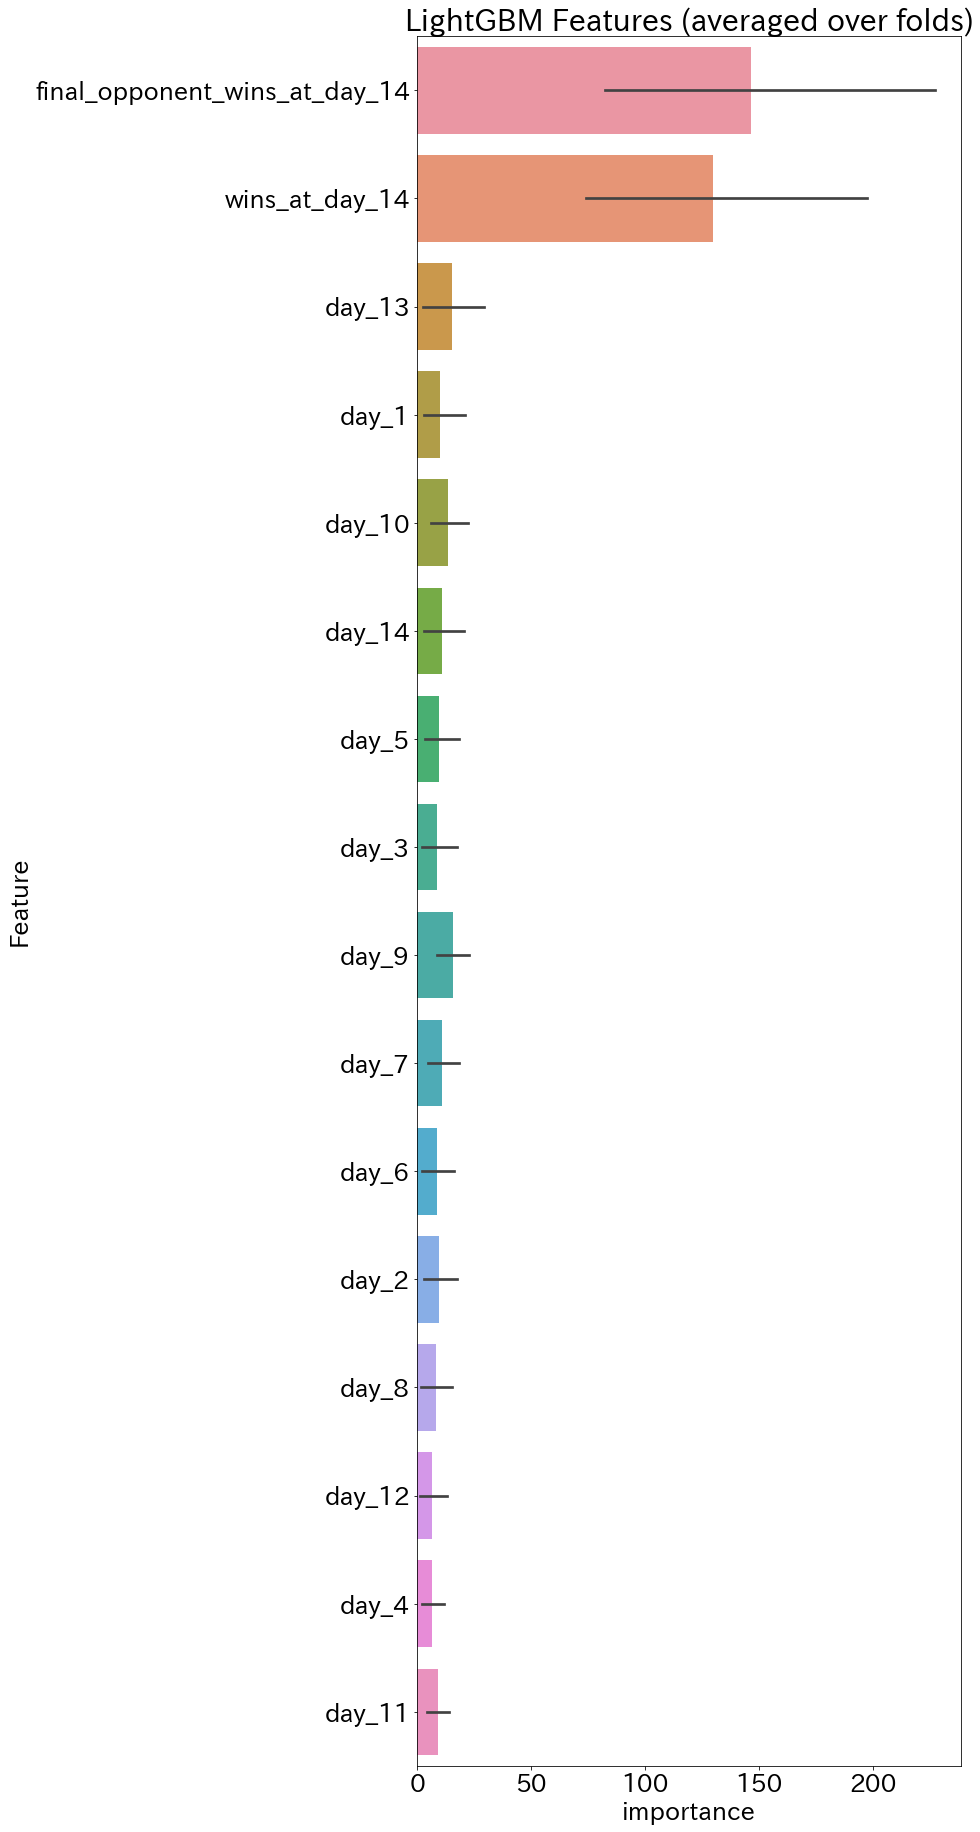

In [29]:
cols = feature_importances.groupby('Feature').mean().sort_values(by="importance", ascending=False)[:200].index

best_features = feature_importances.loc[feature_importances.Feature.isin(cols)]
plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [30]:
y_sub = sum(y_preds) / len(y_preds)
y_sub[:10]

array([0.50108217, 0.41579854, 0.48497158, 0.43867232, 0.48860286,
       0.44218354, 0.53754849, 0.50255432, 0.56308732, 0.44143691])

(array([ 12.,  52., 123., 162., 262., 197., 148.,  64.,  20.,  10.]),
 array([0.37138184, 0.3979901 , 0.42459835, 0.45120661, 0.47781486,
        0.50442312, 0.53103138, 0.55763963, 0.58424789, 0.61085614,
        0.6374644 ]),
 <a list of 10 Patch objects>)

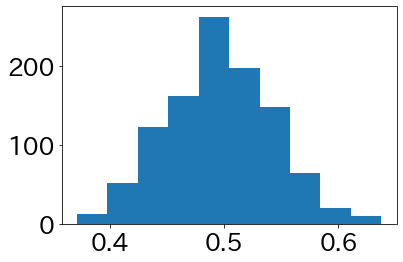

In [31]:
plt.hist(y_sub)

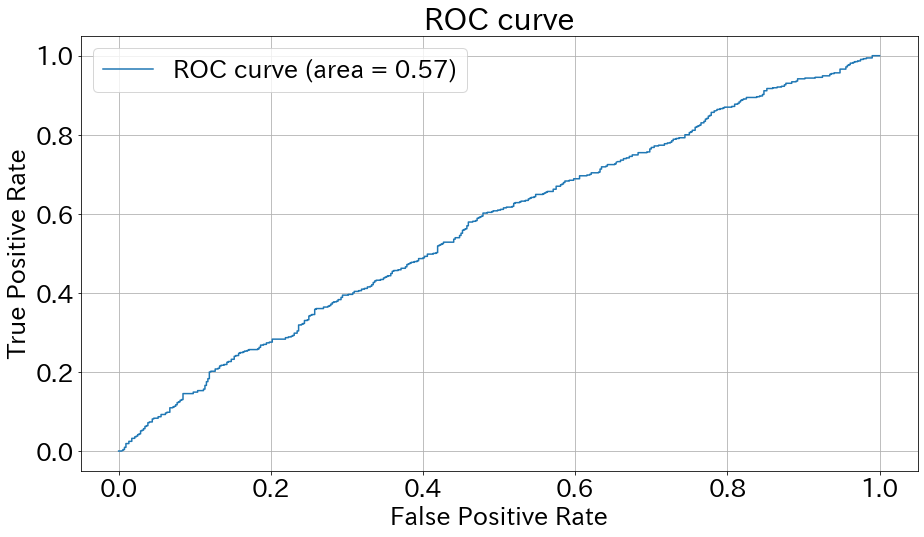

In [32]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_sub)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [33]:
y_sub = np.where(y_sub > 0.5, 1, 0)
y_sub[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_sub)

array([[305, 215],
       [265, 265]])

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_sub)

0.5428571428571428